In [1]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TF version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from sklearn.manifold import TSNE
from scipy import linalg
from tqdm import tqdm

In [4]:
# Utility: display grid of images
def show_image_grid(images, nrow=8, figsize=(6,6), title=None):
    images = (images * 127.5 + 127.5).astype(np.uint8)  # convert [-1,1] to [0,255]
    n = min(len(images), nrow*nrow)
    fig, axes = plt.subplots(nrow, nrow, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < n:
            ax.imshow(images[i])
            ax.axis('off')
        else:
            ax.set_visible(False)
    if title: fig.suptitle(title)
    plt.show()


In [5]:
IMG_SHAPE = (32,32,3)
LATENT_DIM = 128
BATCH_SIZE = 128
EPOCHS = 100        # change to 200+ for better results
BUFFER_SIZE = 50000
LEARNING_RATE = 2e-4
BETA_1 = 0.5

OUT_DIR = "/content/exp14_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
print("Outputs saved to:", OUT_DIR)


Outputs saved to: /content/exp14_outputs


In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 127.5 - 1.0  # scale to [-1,1]
print("Train shape:", x_train.shape)

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train shape: (50000, 32, 32, 3)


In [7]:
def build_generator(latent_dim=LATENT_DIM):
    noise = layers.Input(shape=(latent_dim,))
    x = layers.Dense(4*4*512, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Reshape((4,4,512))(x)

    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False)(x)  # 8x8
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False)(x)  # 16x16
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False)(x)   # 32x32
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    out = layers.Conv2D(3, 3, padding='same', activation='tanh')(x)
    return Model(noise, out, name='Generator')

def build_discriminator(img_shape=IMG_SHAPE):
    inp = layers.Input(shape=img_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inp)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(1)(x)  # logits
    return Model(inp, out, name='Discriminator')

generator = build_generator()
discriminator = build_discriminator()
generator.summary()
discriminator.summary()


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8192)           │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,837,379 (14.64 MB)

 Trainable params: 3,820,099 (14.57 MB)

 Non-trainable params: 17,280 (67.50 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 664,513 (2.53 MB)

 Trainable params: 663,745 (2.53 MB)

 Non-trainable params: 768 (3.00 KB)

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

gen_optimizer = Adam(LEARNING_RATE, beta_1=BETA_1)
disc_optimizer = Adam(LEARNING_RATE, beta_1=BETA_1)

# training step
@tf.function
def train_step_gan(real_images):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, LATENT_DIM])

    # Train discriminator
    with tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)
    grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Train generator
    with tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return gen_loss, disc_loss


In [9]:
import math
sample_noise = tf.random.normal([64, LATENT_DIM])

g_losses = []
d_losses = []

save_every = 5  # save images every n epochs

for epoch in range(1, EPOCHS+1):
    start = time.time()
    epoch_g_loss = []
    epoch_d_loss = []
    for real_batch in train_dataset:
        g_l, d_l = train_step_gan(real_batch)
        epoch_g_loss.append(g_l.numpy())
        epoch_d_loss.append(d_l.numpy())

    g_losses.append(np.mean(epoch_g_loss))
    d_losses.append(np.mean(epoch_d_loss))

    # Generate & save sample grid
    if epoch % save_every == 0 or epoch == 1:
        gen_imgs = generator(sample_noise, training=False).numpy()
        show_image_grid(gen_imgs, nrow=8, figsize=(6,6), title=f"GAN samples — epoch {epoch}")
        np.save(os.path.join(OUT_DIR, f"gan_samples_epoch_{epoch}.npy"), gen_imgs)

    print(f"Epoch {epoch}/{EPOCHS} — gen_loss: {g_losses[-1]:.4f}, disc_loss: {d_losses[-1]:.4f}, time: {time.time()-start:.1f}s")

# Plot loss curves
plt.figure(figsize=(8,4))
plt.plot(g_losses, label='Gen loss')
plt.plot(d_losses, label='Disc loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN training losses')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [10]:
from tensorflow.keras import backend as K

# Encoder
def build_vae_encoder(latent_dim=LATENT_DIM):
    inp = layers.Input(shape=IMG_SHAPE)
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inp)  # 16x16
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)    # 8x8
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)   # 4x4
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    return Model(inp, [z_mean, z_log_var], name='Encoder')

# Decoder
def build_vae_decoder(latent_dim=LATENT_DIM):
    latent = layers.Input(shape=(latent_dim,))
    x = layers.Dense(4*4*128, activation='relu')(latent)
    x = layers.Reshape((4,4,128))(x)
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(x)  # 8x8
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)   # 16x16
    x = layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu')(x)   # 32x32
    out = layers.Conv2D(3, 3, padding='same', activation='tanh')(x)
    return Model(latent, out, name='Decoder')

encoder = build_vae_encoder()
decoder = build_vae_decoder()
encoder.summary()
decoder.summary()

# VAE model & loss
class ConvVAE(Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, LATENT_DIM))
        return self.decode(eps)

    def encode(self, x):
        z_mean, z_log_var = self.encoder(x)
        return z_mean, z_log_var

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        return logits

vae = ConvVAE(encoder, decoder)
optimizer_vae = Adam(1e-4)


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  1,049,088 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     65,664 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,273,664 (4.86 MB)

 Trainable params: 1,273,664 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2048)           │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 8, 8, 128)      │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,267 (2.64 MB)

 Trainable params: 691,267 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

[VAE] Epoch 1/25 loss=498.507 recon=469.817 kl=28.690
[VAE] Epoch 2/25 loss=321.130 recon=274.284 kl=46.847
[VAE] Epoch 3/25 loss=278.147 recon=228.087 kl=50.060
[VAE] Epoch 4/25 loss=258.550 recon=208.440 kl=50.110
[VAE] Epoch 5/25 loss=247.198 recon=197.103 kl=50.094
[VAE] Epoch 6/25 loss=239.107 recon=188.953 kl=50.154
[VAE] Epoch 7/25 loss=233.103 recon=182.834 kl=50.270
[VAE] Epoch 8/25 loss=228.646 recon=178.146 kl=50.500
[VAE] Epoch 9/25 loss=224.775 recon=173.963 kl=50.812
[VAE] Epoch 10/25 loss=221.630 recon=170.435 kl=51.195
[VAE] Epoch 11/25 loss=219.029 recon=167.524 kl=51.506
[VAE] Epoch 12/25 loss=216.582 recon=164.711 kl=51.871
[VAE] Epoch 13/25 loss=214.459 recon=162.207 kl=52.251
[VAE] Epoch 14/25 loss=212.080 recon=159.400 kl=52.680
[VAE] Epoch 15/25 loss=210.172 recon=157.092 kl=53.080
[VAE] Epoch 16/25 loss=208.597 recon=155.197 kl=53.399
[VAE] Epoch 17/25 loss=206.909 recon=153.132 kl=53.777
[VAE] Epoch 18/25 loss=205.619 recon=151.447 kl=54.172
[VAE] Epoch 19/25 l

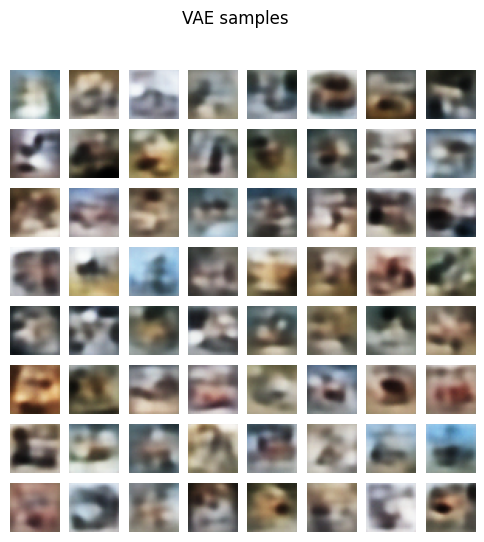

In [11]:
mse_loss_fn = tf.keras.losses.MeanSquaredError()

@tf.function
def train_step_vae(x):
    with tf.GradientTape() as tape:
        z_mean, z_log_var = vae.encode(x)
        z = vae.reparameterize(z_mean, z_log_var)
        x_logit = vae.decode(z)
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_logit), axis=[1,2,3]))  # MSE sum per image
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        loss = recon_loss + vae.beta * kl_loss
    grads = tape.gradient(loss, vae.trainable_variables)
    optimizer_vae.apply_gradients(zip(grads, vae.trainable_variables))
    return loss, recon_loss, kl_loss

# Train for fewer epochs to save time, or adjust
vae_epochs = max(10, EPOCHS//4)

vae_losses, vae_recon, vae_kl = [], [], []
for epoch in range(1, vae_epochs+1):
    l_epoch, r_epoch, k_epoch = [], [], []
    for batch in train_dataset:
        l, r, k = train_step_vae(batch)
        l_epoch.append(l.numpy()); r_epoch.append(r.numpy()); k_epoch.append(k.numpy())
    vae_losses.append(np.mean(l_epoch)); vae_recon.append(np.mean(r_epoch)); vae_kl.append(np.mean(k_epoch))
    print(f"[VAE] Epoch {epoch}/{vae_epochs} loss={vae_losses[-1]:.3f} recon={vae_recon[-1]:.3f} kl={vae_kl[-1]:.3f}")

# sample from VAE
z = tf.random.normal([64, LATENT_DIM])
vae_samples = vae.decode(z).numpy()
show_image_grid(vae_samples, nrow=8, figsize=(6,6), title="VAE samples")


In [12]:
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))  # we'll resize to 75x75 (or 299)
inception.trainable = False

def resize_for_inception(images, size=(75,75)):
    # images expected in [-1,1]
    imgs = (images + 1.0) * 127.5
    imgs = tf.image.resize(imgs, size)
    return imgs

def get_inception_activations(images, batch_size=64):
    images_resized = resize_for_inception(images)
    images_pre = preprocess_input(images_resized)  # scales to expected range
    act = inception.predict(images_pre, batch_size=batch_size, verbose=0)
    return act

def calculate_fid(real_images, generated_images, batch_size=64):
    # real_images, generated_images in [-1,1], uint8 or float32
    act1 = get_inception_activations(real_images, batch_size)
    act2 = get_inception_activations(generated_images, batch_size)
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return float(fid)

# Inception Score (approx): using softmax predictions from InceptionV3 top classifier is standard,
# but we can approximate by using a pre-trained classifier. Here we reuse Inception but need a softmax head:
from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions
inc_model_for_is = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')

def inception_score(images, splits=10):
    # images in [-1,1]
    imgs = resize_for_inception(images, size=(299,299))
    imgs = preprocess_input(imgs)
    preds = inc_model_for_is.predict(imgs, batch_size=64, verbose=0)
    # convert logits to probabilities
    p_yx = tf.nn.softmax(preds).numpy()
    # compute KL divergence between p(y|x) and p(y)
    scores = []
    n_part = p_yx.shape[0] // splits
    for i in range(splits):
        part = p_yx[i*n_part:(i+1)*n_part, :]
        py = np.mean(part, axis=0)
        kl = part * (np.log(part + 1e-16) - np.log(py + 1e-16))
        kl_sum = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl_sum))
    return float(np.mean(scores)), float(np.std(scores))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
Computing FID (this may take a few minutes)...


/tmp/ipython-input-2459069632.py:23: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
/tmp/ipython-input-2459069632.py:23: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


FID — GAN: 299.068, VAE: 766.376
Computing Inception Score (approx)...
IS — GAN: 1.000 ± 0.000, VAE: 1.000 ± 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


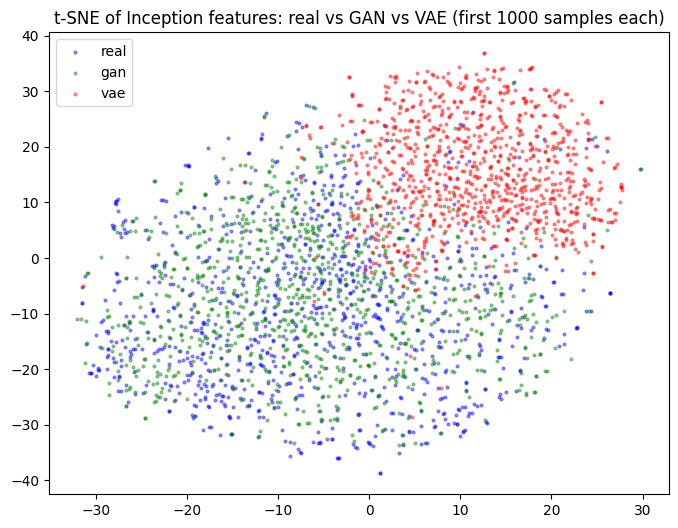

In [13]:
# Collect N samples from each model
N_EVAL = 2000  # number of samples to use for evaluation (increase for more accurate metrics)

# real samples
real_samples = x_train[np.random.choice(len(x_train), N_EVAL, replace=False)].astype('float32')

# GAN samples
z = tf.random.normal([N_EVAL, LATENT_DIM])
gan_samples = generator.predict(z, batch_size=64)
gan_samples = np.clip(gan_samples, -1, 1)

# VAE samples
z = tf.random.normal([N_EVAL, LATENT_DIM])
vae_samples_eval = vae.decode(z).numpy()
vae_samples_eval = np.clip(vae_samples_eval, -1, 1)

print("Computing FID (this may take a few minutes)...")
fid_gan = calculate_fid(real_samples, gan_samples)
fid_vae = calculate_fid(real_samples, vae_samples_eval)
print(f"FID — GAN: {fid_gan:.3f}, VAE: {fid_vae:.3f}")

print("Computing Inception Score (approx)...")
is_gan_mean, is_gan_std = inception_score(gan_samples, splits=10)
is_vae_mean, is_vae_std = inception_score(vae_samples_eval, splits=10)
print(f"IS — GAN: {is_gan_mean:.3f} ± {is_gan_std:.3f}, VAE: {is_vae_mean:.3f} ± {is_vae_std:.3f}")

# t-SNE of inception features (visual diversity)
acts_real = get_inception_activations(real_samples)
acts_gan = get_inception_activations(gan_samples)
acts_vae = get_inception_activations(vae_samples_eval)

# concatenate and reduce
X = np.concatenate([acts_real[:1000], acts_gan[:1000], acts_vae[:1000]], axis=0)
labels = (['real']*1000) + (['gan']*1000) + (['vae']*1000)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
Z = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
idx = 0
for label, color in [('real','blue'), ('gan','green'), ('vae','red')]:
    subset = Z[idx:idx+1000]
    plt.scatter(subset[:,0], subset[:,1], s=4, alpha=0.4, label=label, c=color)
    idx += 1000
plt.legend()
plt.title('t-SNE of Inception features: real vs GAN vs VAE (first 1000 samples each)')
plt.show()
